<a href="https://colab.research.google.com/github/simplekomal/delta-demo/blob/main/Smart%20Travel%20Destination%20Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
df = pd.read_csv('/content/sample_data/Travel_details_dataset.csv')

# Display the first few rows of the dataset
df.head()


,Trip ID,Destination,Start date,End date,Duration (days),Traveler name,Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost
0,1,"London, UK",05-01-2023,05-08-2023,7.0,John Smith,35.0,Male,American,Hotel,1200,Flight,600
1,2,"Phuket, Thailand",6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Resort,800,Flight,500
2,3,"Bali, Indonesia",07-01-2023,07-08-2023,7.0,David Lee,45.0,Male,Korean,Villa,1000,Flight,700
3,4,"New York, USA",8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Hotel,2000,Flight,1000
4,5,"Tokyo, Japan",09-10-2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Airbnb,700,Train,200


In [3]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values or drop rows (depends on your analysis)
# Fill missing values in numeric columns with the mean
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)



Trip ID                 0
Destination             2
Start date              2
End date                2
Duration (days)         2
Traveler name           2
Traveler age            2
Traveler gender         2
Traveler nationality    2
Accommodation type      2
Accommodation cost      2
Transportation type     3
Transportation cost     3
dtype: int64


In [4]:
# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Destination', 'Traveler gender', 'Traveler nationality', 'Accommodation type', 'Transportation type'])

# Display the encoded data
df_encoded.head()


,Trip ID,Start date,End date,Duration (days),Traveler name,Traveler age,Accommodation cost,Transportation cost,Destination_Amsterdam,"Destination_Amsterdam, Netherlands",...,Accommodation type_Villa,Transportation type_Airplane,Transportation type_Bus,Transportation type_Car,Transportation type_Car rental,Transportation type_Ferry,Transportation type_Flight,Transportation type_Plane,Transportation type_Subway,Transportation type_Train
0,1,05-01-2023,05-08-2023,7.0,John Smith,35.0,1200,600,False,False,...,False,False,False,False,False,False,True,False,False,False
1,2,6/15/2023,6/20/2023,5.0,Jane Doe,28.0,800,500,False,False,...,False,False,False,False,False,False,True,False,False,False
2,3,07-01-2023,07-08-2023,7.0,David Lee,45.0,1000,700,False,False,...,True,False,False,False,False,False,True,False,False,False
3,4,8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,2000,1000,False,False,...,False,False,False,False,False,False,True,False,False,False
4,5,09-10-2023,9/17/2023,7.0,Kim Nguyen,26.0,700,200,False,False,...,False,False,False,False,False,False,False,False,False,True


In [5]:
for col in ['Accommodation cost', 'Transportation cost']:
    df[col] = df[col].astype(str) \
                     .str.replace(r'[^\d.]', '', regex=True) \
                     .replace('', np.nan)  # Replace empty strings with NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float safely


In [6]:

# Option 1: Fill missing values with column mean
df[['Accommodation cost', 'Transportation cost']] = df[['Accommodation cost', 'Transportation cost']].fillna(df[['Accommodation cost', 'Transportation cost']].mean())

# Option 2: Or drop rows with missing values (less preferred for clustering)
# df.dropna(subset=['Accommodation cost', 'Transportation cost'], inplace=True)


In [7]:
from sklearn.preprocessing import StandardScaler

features = ['Traveler age', 'Duration (days)', 'Accommodation cost', 'Transportation cost']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:5])


[[ 0.25818344 -0.38249821 -0.03410051 -0.07844345]
 [-0.73220823 -1.64520314 -0.3364804  -0.25205305]
 [ 1.67302867 -0.38249821 -0.18529045  0.09516614]
 [-0.5907237   4.03696905  0.57065928  0.61599492]
 [-1.01517727 -0.38249821 -0.41207537 -0.77288183]]


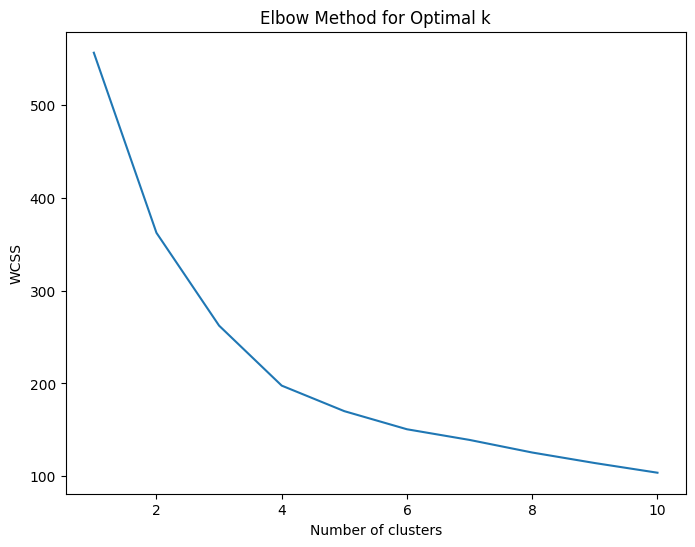

In [8]:
# Find the optimal number of clusters using the Elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # Trying k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [9]:
# Applying k-Means with the optimal number of clusters
k = 3  # Example: optimal number of clusters found
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_scaled)

# Add the cluster label to the original dataframe
df['Cluster'] = y_kmeans


In [10]:
# Group by clusters and compute the mean for each feature
cluster_analysis = df.groupby('Cluster')[features].mean()
print(cluster_analysis)


         Traveler age  Duration (days)  Accommodation cost  \
Cluster                                                      
0           28.849409         8.002520          875.240702   
1           41.125000         7.062500         1157.291667   
2           30.571429         6.571429         6285.714286   

         Transportation cost  
Cluster                       
0                 494.766282  
1                 637.920496  
2                2500.000000  


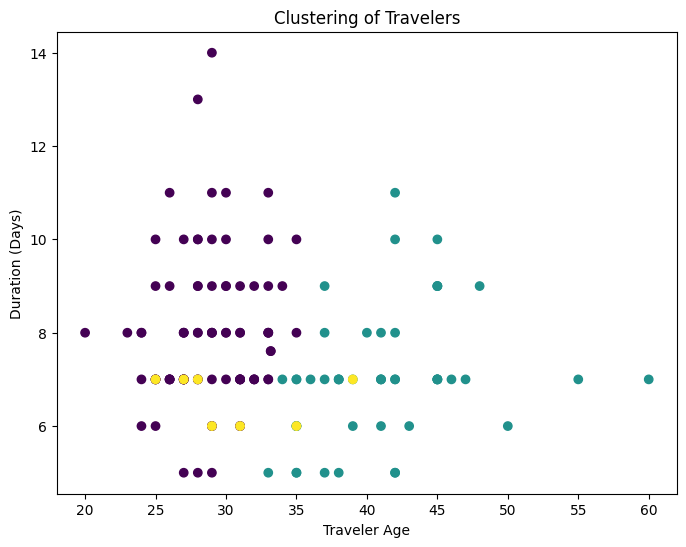

In [11]:
# Plot the clusters using two features (e.g., 'Traveler age' and 'Duration (days)')
plt.figure(figsize=(8, 6))
plt.scatter(df['Traveler age'], df['Duration (days)'], c=df['Cluster'], cmap='viridis')
plt.title('Clustering of Travelers')
plt.xlabel('Traveler Age')
plt.ylabel('Duration (Days)')
plt.show()


In [13]:
def recommend_destinations(traveler_profile):
    # Define the feature names used during scaling
    feature_names = ['Traveler age', 'Duration (days)', 'Accommodation cost', 'Transportation cost']

    # Convert the input profile into a DataFrame with the same column names
    profile_df = pd.DataFrame([traveler_profile], columns=feature_names)

    # Scale the input profile
    traveler_profile_scaled = scaler.transform(profile_df)

    # Predict the cluster of the input traveler profile
    predicted_cluster = kmeans.predict(traveler_profile_scaled)

    # Get the destinations in the same cluster
    recommended_destinations = df[df['Cluster'] == predicted_cluster[0]]['Destination'].dropna().unique()

    return recommended_destinations


In [14]:
# Example traveler profile: [Age, Duration (days), Accommodation cost, Transportation cost]
traveler_profile = [30, 7, 500, 200]

# Get the recommendations
recommended_destinations = recommend_destinations(traveler_profile)
print("Recommended Destinations:", recommended_destinations)


Recommended Destinations: ['Phuket, Thailand' 'New York, USA' 'Tokyo, Japan' 'Sydney, Australia'
 'Rio de Janeiro, Brazil' 'Amsterdam, Netherlands' 'Cancun, Mexico'
 'Honolulu, Hawaii' 'Marrakech, Morocco' 'Edinburgh, Scotland' 'Paris'
 'Bali' 'New York' 'Sydney' 'Rome' 'Hawaii' 'Barcelona' 'Japan' 'France'
 'Australia' 'Brazil' 'Greece' 'Italy' 'Spain' 'Paris, France'
 'Barcelona, Spain' 'Bangkok, Thailand' 'Vancouver, Canada' 'Sydney, AUS'
 'London, UK' 'Seoul, South Korea' 'Los Angeles, USA' 'Rome, Italy'
 'Tokyo' 'Cape Town' 'Bangkok' 'Cape Town, SA' 'Bali, Indonesia'
 'Bangkok, Thai' 'Phuket, Thai' 'London' 'Dubai' 'Seoul' 'Rio de Janeiro'
 'Santorini' 'Sydney, Aus' 'Athens, Greece']
